# Libraries

In [1]:
import sample_households
import numpy as np
import csv

# Functions

In [2]:
def sample_households(n: int, initial_n: int, household_probs_param: list, locations: np.array, age_distribution_param: list, 
                      mother_age_distribution: np.array, community_id: int, scale_location_var: float = 0.1):
    '''
    Sampling households, according to demographics
    
    Inputs:
        n: Size of the population to generate
        initial_n: Size of the previously generated population
        household_probs_param: [single household, couple without children, single parent +1/2/3 children, 
            couple +1/2/3 children, family without a nucleus, nucleus with other people, 
            households with two or more nuclei (a and b)]
        locations: np.array in format (m, 2) where the axis 1 represents (latitude, longitude)
        age_distribution_param: list or np.array of the ages distribution
        mother_age_distribution: mother age distribution, see => get_mother_birth_age_distribution(country) 
        community_id: index of the community
        scale_location_var: variation allowed on the location latitude and longitude, corresponding to the 
            scale of the logistic regression
            
    Outputs:
        households: table, for each individual, listing the index of the other members of the household
        age: ages of the individuals
        location: location of the individuals (same for all the members of a household)
        community: community of the individuals
    '''
    
    def normalize(vector):
        norm_vec = np.asarray(vector)
        norm_vec = norm_vec/norm_vec.sum()
        return norm_vec
    
    max_household_size = 6
    
    households = []
    
    age = np.zeros(n, dtype=np.int)    
    n_ages = len(age_distribution_param)
    
    community = np.zeros(n, dtype=np.uint8)
    community[:] = community_id    
    
    location = np.zeros((n, 2))

    household_probs = normalize(household_probs_param)
    age_distribution = normalize(age_distribution_param)
    
    # Keeping track of the number of agents
    num_generated = 0
    
    # Age of the mother at first birth, as obtained from fertility data
    mother_birth_age_distribution=get_mother_birth_age_distribution("Italy")    
    renormalized_mother = mother_birth_age_distribution/mother_birth_age_distribution.sum()
    
    renormalized_adult = age_distribution[18:]
    renormalized_adult = renormalized_adult/renormalized_adult.sum()
    # Age = 30 considered as the time when children leave the family home
    # Note: older children in Italy often live with their parents longer than elsewhere
    renormalized_child = age_distribution[:30]
    renormalized_child = renormalized_child/renormalized_child.sum()
    
    renormalized_adult_older = age_distribution[30:]
    renormalized_adult_older /= renormalized_adult_older.sum()
    # Age = 60 considered as retirement threshold (as a first approximation; it could potentially be larger)
    renormalized_grandparent = age_distribution[60:]
    renormalized_grandparent = renormalized_grandparent/renormalized_grandparent.sum()
    
    while num_generated < n:
        if n - num_generated < (max_household_size+1):
            i = 0
        else:
            i = np.random.choice(household_probs.shape[0], p=household_probs)
            loc = locations[int(np.random.uniform(0, len(locations)-1))]
            lat = np.random.logistic(loc[0], scale_location_var)
            lon = np.random.logistic(loc[1], scale_location_var)
        # Single person household
        if i == 0:
            # Sample from left-truncated age distribution (adult aged >= 30)
            age[num_generated]=np.random.randint(30,101)
            generated_this_step = 1
        # Couple with one of the two being 3 years older
        elif i == 1:  
            # Sample from left-truncated age distribution (adult aged >= 30)
            age_adult = np.random.randint(30,101)
            age[num_generated] = age_adult
            # For heterosexual couples, the man is three years older than the woman on average
            age[num_generated+1] = min(n_ages-1,age_adult+3)
            generated_this_step = 2
        # Single parent + 1 child
        elif i == 2:            
            # Child
            child_age = np.random.choice(30, p=renormalized_child)
            age[num_generated] = child_age
            # Parent
            mother_age_at_birth = (np.random.choice(7, p=renormalized_mother) + 3)*5+np.random.randint(5)
            mother_current_age = min(n_ages-1,mother_age_at_birth + child_age)
            age[num_generated + 1] = mother_current_age
            generated_this_step = 2
        # Single parent + 2 children
        elif i == 3:
            # Children
            for j in range(2):                
                child_age = np.random.choice(30, p=renormalized_child)
                age[num_generated+j] = child_age
            # Parent
            mother_age_at_birth = (np.random.choice(7, p=renormalized_mother) + 3)*5+np.random.randint(5)
            mother_current_age = min(n_ages-1,mother_age_at_birth + max(age[num_generated:(num_generated+2)]))
            age[num_generated + 2] = mother_current_age
            generated_this_step = 3
        # Single parent + 3 children
        elif i == 4:
            # Children
            for j in range(3):                
                child_age = np.random.choice(30, p=renormalized_child)
                age[num_generated+j] = child_age
            # Parent
            mother_age_at_birth = (np.random.choice(7, p=renormalized_mother) + 3)*5+np.random.randint(5)
            mother_current_age = min(n_ages-1,mother_age_at_birth + max(age[num_generated:(num_generated+3)]))
            age[num_generated + 3] = mother_current_age
            generated_this_step = 4
            
        # Couple with one of the two being 3 years older + 1 child
        elif i == 5: 
            # Child
            child_age = np.random.choice(30, p=renormalized_child)
            age[num_generated] = child_age
            # Parents
            mother_age_at_birth = (np.random.choice(7, p=renormalized_mother) + 3)*5+np.random.randint(5)
            mother_current_age = min(n_ages-1,mother_age_at_birth + child_age)
            # Populate age for parents
            age[num_generated + 1] = mother_current_age
            age[num_generated + 2] = min(n_ages-1,mother_current_age+3)
            generated_this_step = 3
        
        # Couple with one of the two being 3 years older + 2 children
        elif i == 6:
            # Children
            for j in range(2):                
                child_age = np.random.choice(30, p=renormalized_child)
                age[num_generated+j] = child_age
            # Parents
            mother_age_at_birth = (np.random.choice(7, p=renormalized_mother) + 3)*5+np.random.randint(5)
            mother_current_age = min(n_ages-1,mother_age_at_birth + max(age[num_generated:(num_generated+2)]))
            # Populate age for parents
            age[num_generated + 2] = mother_current_age
            age[num_generated + 3] = min(n_ages-1,mother_current_age+3)
            generated_this_step = 4            
        
        # Couple with one of the two being 3 years older + 3 children
        elif i == 7:
            # Children
            for j in range(3):                
                child_age = np.random.choice(30, p=renormalized_child)
                age[num_generated+j] = child_age
            # Parents
            mother_age_at_birth = (np.random.choice(7, p=renormalized_mother) + 3)*5+np.random.randint(5)
            mother_current_age = min(n_ages-1,mother_age_at_birth + max(age[num_generated:(num_generated+3)]))
            # Populate age for parents
            age[num_generated + 3] = mother_current_age
            age[num_generated + 4] = min(n_ages-1,mother_current_age+3)
            generated_this_step = 5
        
        # Family without nucleus (2 adults >= 30)
        elif i == 8:
            age[num_generated] = np.random.randint(30,101)
            age[num_generated+1] = np.random.randint(30,101)
            generated_this_step = 2         
                
        # Nucleus with other persons (couple with one of the two being three years older + 2 children + 1 adult >= 60)
        elif i == 9:
            # Children
            for j in range(2):                
                child_age = np.random.choice(30, p=renormalized_child)
                age[num_generated+j] = child_age
            # Parents
            mother_age_at_birth = (np.random.choice(7, p=renormalized_mother) + 3)*5+np.random.randint(5)
            mother_current_age = min(n_ages-1,mother_age_at_birth + max(age[num_generated:(num_generated+2)]))
            # Populate age for parents
            age[num_generated + 2] = mother_current_age
            age[num_generated + 3] = min(n_ages-1,mother_current_age+3)
            # Populate age for adult >= 60
            age[num_generated + 4] = np.random.choice(n_ages-60, p=renormalized_grandparent) + 60
            generated_this_step = 5
            
        # Households with 2 or more nuclei
        # Assumption: couple with one of the two being three years older + 2 children <= 30 + 2 grand-parents
        
        elif i == 10:
            # Children
            for j in range(2):                
                child_age = np.random.choice(30, p=renormalized_child)
                age[num_generated+j] = child_age
            # Parents
            mother_age_at_birth = (np.random.choice(7, p=renormalized_mother) + 3)*5+np.random.randint(5)
            mother_current_age = min(n_ages-1,mother_age_at_birth + max(age[num_generated:(num_generated+2)]))
            # Populate age for parents
            age[num_generated + 2] = mother_current_age
            age[num_generated + 3] = min(n_ages-1,mother_current_age+3)
            # Grand-parents
            grandmother_age_at_birth = (np.random.choice(7, p=renormalized_mother) + 3)*5+np.random.randint(5)
            grandmother_current_age = min(n_ages-1,grandmother_age_at_birth + mother_current_age)
            # Populate age for grand-parents
            age[num_generated + 4] = grandmother_current_age
            age[num_generated + 5] = min(n_ages-1,grandmother_current_age+3)   
            generated_this_step = 6
            
        location[num_generated:num_generated+generated_this_step] = (lat, lon)
            
        # Update list of household contacts accordingly 
        for i in range(num_generated, num_generated+generated_this_step):
            household = []
            for j in range(num_generated, num_generated+generated_this_step):
                if j != i:
                    household.append(j + initial_n)
            households.append(household)
        num_generated += generated_this_step
        
    return households, age, location, community

In [3]:
def get_age_distribution(country):
    age_distribution=[]
    with open('World_Age_2019.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if row[0]==country:
                for i in range(101):
                    age_distribution.append(float(row[i+1]))
                break
    return np.array(age_distribution)

def get_mother_birth_age_distribution(country):
    mother_birth_age_distribution=[]
    with open('AgeSpecificFertility.csv',encoding='latin-1') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if row[0]==country:
                #15-19	20-24	25-29	30-34	35-39	40-44	45-49
                for i in range(7):
                    mother_birth_age_distribution.append(float(row[i+1]))
                break
    return np.array(mother_birth_age_distribution)

# Test

In [4]:
N = [1000, 2000, 3000, 4000, 5000]

In [5]:
household_probs = [[0.309179, 0.196000, 0.0694283, 0.0273065, 0.00450268, 0.152655, 0.132429, 0.0200969, 0.049821, 0.033, 0.017], 
                   [0.309179, 0.196000, 0.0694283, 0.0273065, 0.00450268, 0.152655, 0.132429, 0.0200969, 0.049821, 0.033, 0.017], 
                   [0.309179, 0.196000, 0.0694283, 0.0273065, 0.00450268, 0.152655, 0.132429, 0.0200969, 0.049821, 0.033, 0.017], 
                   [0.309179, 0.196000, 0.0694283, 0.0273065, 0.00450268, 0.152655, 0.132429, 0.0200969, 0.049821, 0.033, 0.017], 
                   [0.309179, 0.196000, 0.0694283, 0.0273065, 0.00450268, 0.152655, 0.132429, 0.0200969, 0.049821, 0.033, 0.017]]

In [6]:
locations = [np.asarray([np.random.uniform(0., 10., 1000), np.random.uniform(40., 45., 1000)]).T,
            np.asarray([np.random.uniform(0., 10., 1000), np.random.uniform(40., 45., 1000)]).T,
            np.asarray([np.random.uniform(0., 10., 1000), np.random.uniform(40., 45., 1000)]).T,
            np.asarray([np.random.uniform(0., 10., 1000), np.random.uniform(40., 45., 1000)]).T,
            np.asarray([np.random.uniform(0., 10., 1000), np.random.uniform(40., 45., 1000)]).T]

In [7]:
# Age distribution in CH
age_distribution = [get_age_distribution("Switzerland"), get_age_distribution("Switzerland"),
                   get_age_distribution("Switzerland"), get_age_distribution("Switzerland"),
                   get_age_distribution("Switzerland")]

In [8]:
mother_age_distribution = [get_mother_birth_age_distribution("Switzerland"),
                          get_mother_birth_age_distribution("Switzerland"),
                          get_mother_birth_age_distribution("Switzerland"),
                          get_mother_birth_age_distribution("Switzerland"),
                          get_mother_birth_age_distribution("Switzerland")]

In [9]:
households = []
age, location, community = [], [], []
initial_n = 0

for i in range(len(household_probs)):
    households_, age_, location_, community_ = sample_households(N[i], initial_n, household_probs[i], locations[i], 
                                                                 age_distribution[i], mother_age_distribution[i], i)
    initial_n += N[i]
    households += households_
    age.append(age_)
    location.append(location_)
    community.append(community_)
    
age = np.concatenate(age)
location = np.concatenate(location)
community = np.concatenate(community)

# Commuting

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [164]:
df = pd.read_excel('tabelle.xls', header = 2)[:21].rename(columns = {'Unnamed: 0': 'km_range', 
                'Part des déplacements [%]': 'share'})[['km_range', 'share']]
df['km'] = df.index + 1
df.drop(columns = 'km_range', inplace=True)
commuting_dist = df['share'].values/np.sum(df['share'])

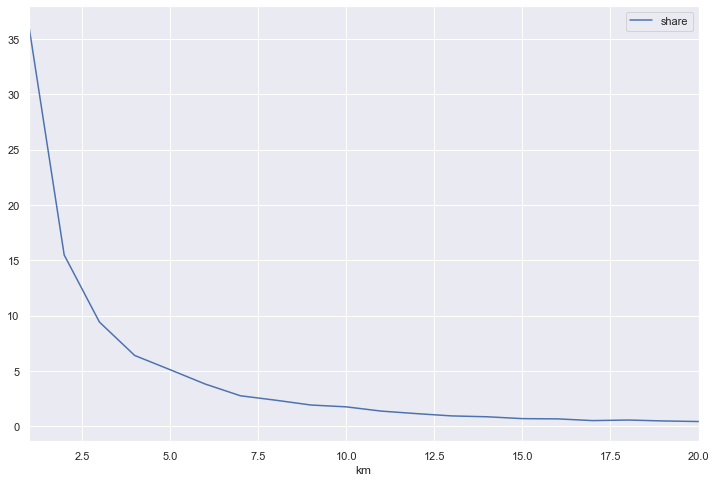

In [44]:
sns.set(rc={'figure.figsize':(12, 8)})
df.plot(y = 'share', x = 'km')